# ML Finance Final Project 
## Portfolio of Algorithmic Trading Strategies on a portfolio of Futures
Pierre Andurand (pa2570)
Ping-Feng Lin (pl2730)
Jack Yao (yy2857)


This Notebook runs everything from the project, except ATS parameter optimization which we decided not to use because of over fitting. 

Here we input the portfolio of futures, lots size, start of training period, end of testing period, and percentage of data which is kept for testing and AUM. 

We choose test_size=0.5 here

## 1) Imports, inputs and functions for AdaBoost and Random Forest

In [1]:

#Traditional ML methods on portfolio of contracts: Adaboost and Random Forests


#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score
import pdblp   #for Bloomberg API
import os
import sys

from scipy.optimize import minimize  #For minimizing and finding weights
from matplotlib.backends.backend_pdf import PdfPages #for sending resulting plots in a pdf file


pp = PdfPages('Results_50.pdf') # for AdaBoost and Random Forest results, and full portfolio
pp2 = PdfPages('Results_ATSopt_50.pdf') # for the ATS portfolio optimization

global test_size #percentage of testing data

##########FOR PYTHON############

#answer='Y'
#assets=[]
#lot_size = []
#print("####Entering assets for the portfolio to test and trade####")

#while answer=='Y':
#    ticker = input("Enter a Bloomberg ticker to test and trade: ")
#    assets.append(ticker)
#    answer = input("Would you like to enter another ticker? (Y/N): ")
#    lotsize = int(input("Lot size? (integer): "))
#    lot_size.append(lotsize)

#start_date = input("Enter start date of training (YYYMMDD): ")
#end_date = input("Enter end date of testing (YYYMMDD): ")
#test_size = float(input("Enter percentage of testing data (float): "))
#aum = input("Amount of money under management?")

################################



#############INPUTS#############################
aum=500000000 #Money under management
assets = ['CO1 COMDTY','SP1 INDEX','TY1 COMDTY','HG1 COMDTY', 'NQ1 INDEX', 'GC1 COMDTY']
#Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures
lot_size=[1000,250,1000,250,20,100] #1 point move generates that amount in USD (per asset)
start_date='20000101'
end_date='20200807'

test_size=0.5
##########################FUNCTIONS TO BE USED### CAN BE PUT IN LIBRARY LATER#############

#Load data from Bloomberg

def bbloadML(ticker, start_date,end_date):

    con = pdblp.BCon(debug=False, port=8194, timeout=5000)
    con.start()
    a = con.bdh(ticker, ['PX_LAST', 'FUT_AGGTE_VOL'],  start_date, end_date )
    a.columns=['close','volume']

    return a

# Take a dataframe of daily prices, volume and open interest, and output dataframe of daily features (for each contract)
def featureML(df):

    df1=pd.DataFrame()
    df1['ret']=np.log(df.close/df.close.shift(1))
    df1['ma50']=df.close/df.close.rolling(50).mean()-1 #how much above or below we are relative to 50 day moving average in %
    df1['ma8']=df.close/df.close.rolling(8).mean()-1 #how much above or below we are relative to 8 day moving average in %
    df1['ma20']=df.close/df.close.rolling(20).mean()-1 #how much above or below we are relative to 20 day moving average in %
    df1['ma100']=df.close/df.close.rolling(100).mean()-1 #how much above or below we are relative to 100 day moving average in %
    df1['ma200']=df.close/df.close.rolling(200).mean()-1 #how much above or below we are relative to 200 day moving average in %
    df1['RSI']=rsi(df.close,14)/100 #RSI 14 days
    df1['volatility']=df1.ret.rolling(20).std()*np.sqrt(252) #historical 20-day volatility annualized
    df1['volatility1M']=df1.volatility-df1.volatility.rolling(20).mean() #historical 20-day volatility annualized
    #not using implied vol for now as many nan
    return df1

#RSI function
def rsi(prices, n=14):
    pricediff=prices-prices.shift(1)
    upmove=pd.Series()
    downmove=pd.Series()
    RS=pd.Series()
    RSI=pd.Series()
    upmove=pd.Series([pricediff[i] if pricediff[i]>0 else 0 for i in range(len(pricediff))])
    downmove=pd.Series([-pricediff[i] if pricediff[i]<0 else 0 for i in range(len(pricediff))])
    RS=upmove.rolling(n).mean()/downmove.rolling(n).mean()
    RSI=100-100/(1+RS)
    RSI.index=prices.index
    return RSI
    
# sharpe for return series (the standard)
def	sharpe(logret):
    n = len(logret)
    p=np.exp(logret.sum())**(252/n)-1
    s=np.std(logret)*np.sqrt(252)
    return p/s    

def annreturn(logret):
    n = len(logret)
    r=np.exp(logret.sum())**(252/n)-1
    return r 

def showmetrics(cumpath_mean, in_or_out_of_sample, model):
    #model is name of model (string)
    n=len(cumpath_mean)
    totret=cumpath_mean[-1]-1
    anret=(totret+1)**(252/n)-1
    averageret=cumpath_mean/cumpath_mean.shift(1)-1
    avgvol=np.std(averageret)*np.sqrt(252)
    sharperatio=anret/avgvol
    print("Portfolio Sharpe "+ in_or_out_of_sample + ", "+ model+": ",round(sharperatio,2))
    print("Annualized returns "+ in_or_out_of_sample + ", "+ model+": ", round(anret,4))
    print("Annualized volatility "+ in_or_out_of_sample + ", "+ model+": ", round(avgvol,4))
    


In [2]:
# Loading and creating dataframes of features

prices_dict=dict()
features_dict=dict()
for asset in assets:
    print("##### Loading "+asset+" and creating features dataframe\n")
    prices = bbloadML(asset, start_date,end_date).dropna()
    features = featureML(prices)
    prices_dict[asset[:3]]=prices
    features_dict[asset[:3]]=features.dropna()




##### Loading CO1 COMDTY and creating features dataframe

##### Loading SP1 INDEX and creating features dataframe

##### Loading TY1 COMDTY and creating features dataframe

##### Loading HG1 COMDTY and creating features dataframe

##### Loading NQ1 INDEX and creating features dataframe

##### Loading GC1 COMDTY and creating features dataframe



C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for AdaBoost  on test set for CO1:  [[584 605]
 [653 700]]
AdaBoost accuracy on test set for CO1:  0.5051140833988985
AdaBoost precision on test set for CO1:  0.5173688100517368
Confusion matrix for AdaBoost on train set for CO1:  [[1100  106]
 [ 117 1218]]
AdaBoost accuracy on train set for CO1:  0.9122392758756395
AdaBoost precision on train set for CO1:  0.9123595505617977


C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


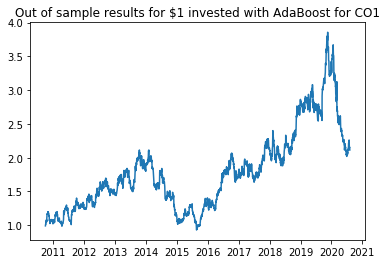

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for AdaBoost  on test set for SP1:  [[  70   77]
 [1042 1324]]
AdaBoost accuracy on test set for SP1:  0.5547154795065659
AdaBoost precision on test set for SP1:  0.5595942519019442
Confusion matrix for AdaBoost on train set for SP1:  [[ 203  130]
 [ 939 1240]]
AdaBoost accuracy on train set for SP1:  0.5744426751592356
AdaBoost precision on train set for SP1:  0.5690683799908215


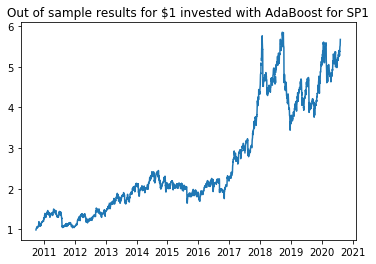

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for AdaBoost  on test set for TY1:  [[304 371]
 [856 960]]
AdaBoost accuracy on test set for TY1:  0.5074267362505018
AdaBoost precision on test set for TY1:  0.5286343612334802
Confusion matrix for AdaBoost on train set for TY1:  [[ 359  232]
 [ 784 1115]]
AdaBoost accuracy on train set for TY1:  0.5919678714859438
AdaBoost precision on train set for TY1:  0.5871511321748288


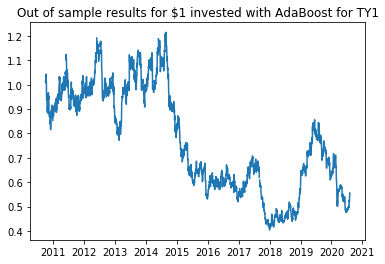

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for AdaBoost  on test set for HG1:  [[439 416]
 [794 830]]
AdaBoost accuracy on test set for HG1:  0.5118999596611536
AdaBoost precision on test set for HG1:  0.5110837438423645
Confusion matrix for AdaBoost on train set for HG1:  [[461 375]
 [723 920]]
AdaBoost accuracy on train set for HG1:  0.5570794675272287
AdaBoost precision on train set for HG1:  0.5599513085818625


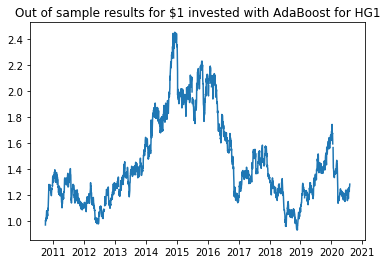

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for AdaBoost  on test set for NQ1:  [[ 267  339]
 [ 817 1091]]
AdaBoost accuracy on test set for NQ1:  0.5401750198886237
AdaBoost precision on test set for NQ1:  0.5718029350104822
Confusion matrix for AdaBoost on train set for NQ1:  [[ 607  262]
 [ 568 1076]]
AdaBoost accuracy on train set for NQ1:  0.6697174691603661
AdaBoost precision on train set for NQ1:  0.6545012165450121


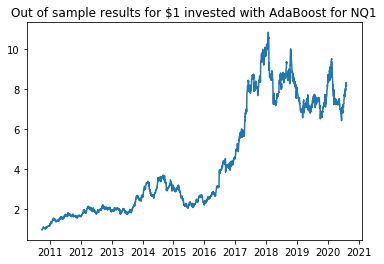

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for AdaBoost  on test set for GC1:  [[  83   74]
 [1124 1198]]
AdaBoost accuracy on test set for GC1:  0.5167406212182332
AdaBoost precision on test set for GC1:  0.5159345391903531
Confusion matrix for AdaBoost on train set for GC1:  [[ 159  137]
 [ 970 1213]]
AdaBoost accuracy on train set for GC1:  0.5534489713594192
AdaBoost precision on train set for GC1:  0.5556573522675218


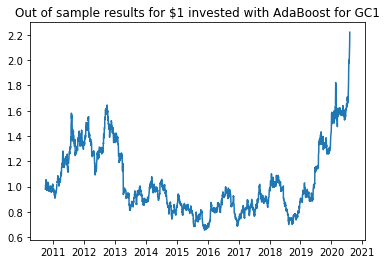

Portfolio Sharpe out_sample, AdaBoost:  0.82
Annualized returns out_sample, AdaBoost:  0.1302
Annualized volatility out_sample, AdaBoost:  0.1587
Portfolio Sharpe in_sample, AdaBoost:  64.08
Annualized returns in_sample, AdaBoost:  13.0439
Annualized volatility in_sample, AdaBoost:  0.2036


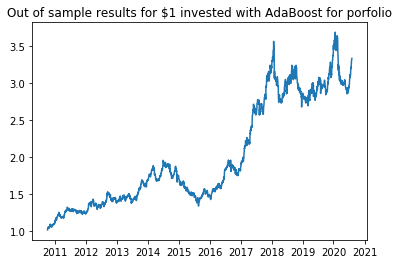

In [3]:
#Defining MLmodel function, and running AdaBoost

Ada = AdaBoostClassifier(n_estimators=100,algorithm='SAMME',random_state=0)
parameters = {'base_estimator':(DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),
                                   DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4),
                                    DecisionTreeClassifier(max_depth=5))}
Ada = GridSearchCV(Ada, parameters)


def MLmodel(model, model_name, features_dict, test_size, assets, prices_dict,pp):

    cumpath=pd.DataFrame()
    oosreturn=pd.DataFrame()
    iscumpath=pd.DataFrame()
    isreturn=pd.DataFrame()
    positions=pd.DataFrame()
    #Putting equal weight in each strategy at start
    i=0
    for asset in assets:
        clf = model
        name=asset[:3]
        X=features_dict[name]
        Y=np.sign(features_dict[name].ret.shift(-1)[:-1])
        mask=[i for i in range(len(Y)) if Y[i]==0]
        Y[mask]=1.
        Y=Y.astype(int)
        X_train, X_test, Y_train, Y_test = train_test_split(X[:-1], Y, test_size=test_size, shuffle=False, random_state=42)
        clf.fit(X_train,Y_train)
        Ypred = clf.predict(X_test)
        print("Confusion matrix for "+model_name+"  on test set for "+name+": ",confusion_matrix(Y_test,Ypred).T)
        print(model_name+" accuracy on test set for "+name+": ",accuracy_score(Y_test, Ypred))
        print(model_name+" precision on test set for "+name+": ",precision_score(Y_test, Ypred))
        Ypred_train = clf.predict(X_train)
        print("Confusion matrix for "+model_name+" on train set for "+name+": ",confusion_matrix(Y_train,Ypred_train).T)
        print(model_name+" accuracy on train set for "+name+": ",accuracy_score(Y_train, Ypred_train))
        print(model_name+" precision on train set for "+name+": ",precision_score(Y_train, Ypred_train))
        isreturn[name]=Ypred_train*X_train.ret.shift(-1)*0.25/X_train.volatility
        oosreturn[name]=Ypred*X_test.ret.shift(-1)*0.25/X_test.volatility
        iscumpath[name]=isreturn[name].cumsum().apply(np.exp)
        M=len(prices_dict[name].close)
        N=len(Ypred)
        positions[name]=Ypred*(0.25/X_test.volatility)*aum/lot_size[i]/len(assets)
        positions[name]=positions[name]/prices_dict[name].close[-1-N:-1]
        iscumpath[name]=isreturn[name].cumsum().apply(np.exp)
        cumpath[name]=oosreturn[name].cumsum().apply(np.exp)
        plt.plot(cumpath[name])
        plt.title("Out of sample results for $1 invested with "+model_name+" for "+name)
        pp.savefig()
        plt.show()
        plt.close()
        
        i+=1

    plt.plot(cumpath.dropna().mean(axis=1)) #Only trading when all contracts are trading on a given day
    plt.title("Out of sample results for $1 invested with "+model_name+" for porfolio")

    showmetrics(cumpath.dropna().mean(axis=1), in_or_out_of_sample='out_sample', model=model_name)
    showmetrics(iscumpath.dropna().mean(axis=1), in_or_out_of_sample='in_sample', model=model_name)     
        
    return iscumpath, cumpath, positions    

  
iscumpath_ada, cumpath_ada, positions_ada = MLmodel(model=Ada, model_name='AdaBoost', 
                                                    features_dict=features_dict, test_size=test_size, assets=assets, 
                                                    prices_dict=prices_dict, pp=pp)


   
   






C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for Random Forest  on test set for CO1:  [[  73   66]
 [1164 1239]]
Random Forest accuracy on test set for CO1:  0.5161290322580645
Random Forest precision on test set for CO1:  0.5156054931335831
Confusion matrix for Random Forest on train set for CO1:  [[ 120   67]
 [1097 1257]]
Random Forest accuracy on train set for CO1:  0.5419126328217237
Random Forest precision on train set for CO1:  0.5339847068819031


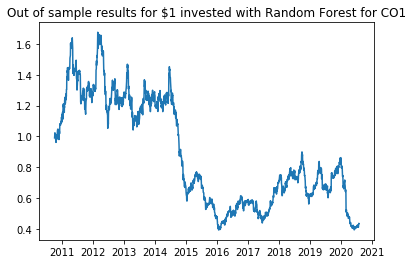

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for Random Forest  on test set for SP1:  [[   5    4]
 [1107 1397]]
Random Forest accuracy on test set for SP1:  0.5578989255869479
Random Forest precision on test set for SP1:  0.5579073482428115
Confusion matrix for Random Forest on train set for SP1:  [[  20    6]
 [1122 1364]]
Random Forest accuracy on train set for SP1:  0.5509554140127388
Random Forest precision on train set for SP1:  0.5486725663716814


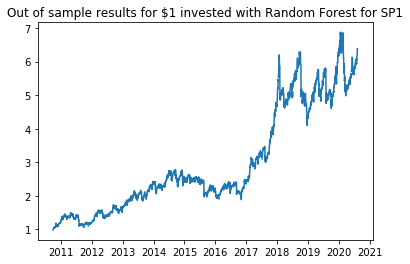

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for Random Forest  on test set for TY1:  [[   0    0]
 [1160 1331]]
Random Forest accuracy on test set for TY1:  0.5343235648334003
Random Forest precision on test set for TY1:  0.5343235648334003
Confusion matrix for Random Forest on train set for TY1:  [[   0    0]
 [1143 1347]]
Random Forest accuracy on train set for TY1:  0.5409638554216868
Random Forest precision on train set for TY1:  0.5409638554216868


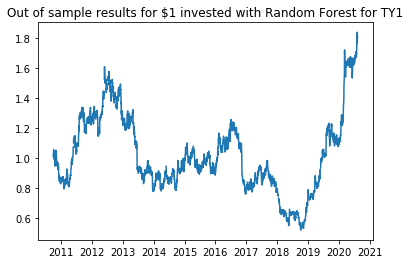

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for Random Forest  on test set for HG1:  [[301 268]
 [932 978]]
Random Forest accuracy on test set for HG1:  0.5159338442920532
Random Forest precision on test set for HG1:  0.512041884816754
Confusion matrix for Random Forest on train set for HG1:  [[ 359  194]
 [ 825 1101]]
Random Forest accuracy on train set for HG1:  0.5889471561113352
Random Forest precision on train set for HG1:  0.5716510903426791


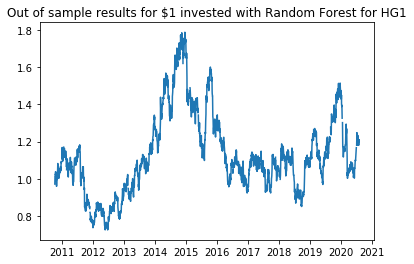

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for Random Forest  on test set for NQ1:  [[  60   94]
 [1024 1336]]
Random Forest accuracy on test set for NQ1:  0.5552903739061257
Random Forest precision on test set for NQ1:  0.5661016949152542
Confusion matrix for Random Forest on train set for NQ1:  [[ 317  221]
 [ 858 1117]]
Random Forest accuracy on train set for NQ1:  0.5706327099084759
Random Forest precision on train set for NQ1:  0.5655696202531646


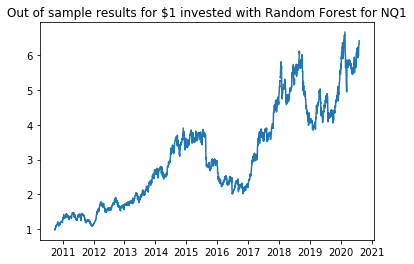

C:\Users\pandurand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Confusion matrix for Random Forest  on test set for GC1:  [[   6    2]
 [1201 1270]]
Random Forest accuracy on test set for GC1:  0.5147236789027834
Random Forest precision on test set for GC1:  0.5139619587211656
Confusion matrix for Random Forest on train set for GC1:  [[  19    9]
 [1110 1341]]
Random Forest accuracy on train set for GC1:  0.5486083098023397
Random Forest precision on train set for GC1:  0.5471236230110159


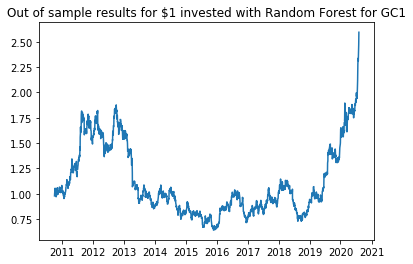

Portfolio Sharpe out_sample, Random Forest:  0.7
Annualized returns out_sample, Random Forest:  0.1234
Annualized volatility out_sample, Random Forest:  0.1759
Portfolio Sharpe in_sample, Random Forest:  3.03
Annualized returns in_sample, Random Forest:  0.5158
Annualized volatility in_sample, Random Forest:  0.1702


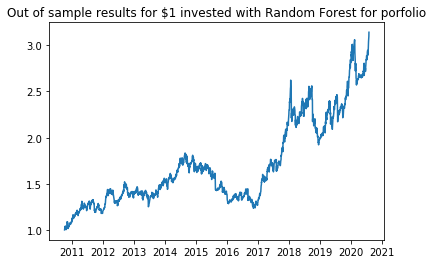

In [4]:
#Running Random Forest 


RF = RandomForestClassifier(n_estimators=50,random_state=0)
parameters = {'max_depth':[1,2,3,4,5,6]}
RF = GridSearchCV(RF, parameters)

iscumpath_rf, cumpath_rf, positions_rf = MLmodel(model=RF, model_name='Random Forest', features_dict=features_dict, test_size=test_size, assets=assets, prices_dict=prices_dict,pp=pp)


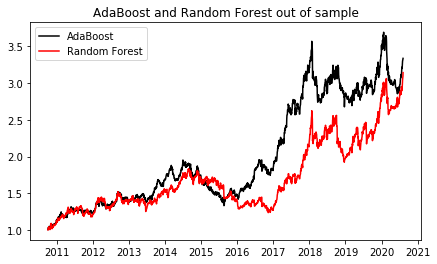

In [5]:
#Plot AdaBoost and Random Forest
plt.figure(figsize=(7,4))
plt.plot(cumpath_ada.dropna().mean(axis=1), label='AdaBoost', color='k')
plt.plot(cumpath_rf.dropna().mean(axis=1), label='Random Forest', color='r') #Only trading when all contracts are trading on a given day
plt.title("AdaBoost and Random Forest out of sample")
plt.legend()
pp.savefig()
plt.show()

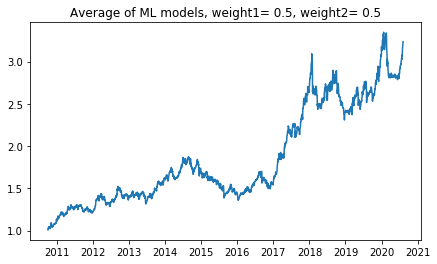

Portfolio Sharpe out of sample, average ML:  0.82
Annualized returns out of sample, average ML:  0.1269
Annualized volatility out of sample, average ML:  0.1549


In [6]:
#Average AdaBoost and Random Forest

def plot_average_ML(cumpath, cumpath2, weight1, weight2,pp):

    path1=cumpath.dropna().mean(axis=1)
    path2=cumpath2.dropna().mean(axis=1)
    average_mean=weight1*path1+weight2*path2
    average_all=weight1*cumpath.dropna()+weight2*cumpath2.dropna()
    plt.figure(figsize=(7,4))
    plt.plot(average_mean)
    plt.title('Average of ML models, weight1= '+str(weight1)+', weight2= '+str(weight2))
    pp.savefig()
    plt.show()
    return average_mean, average_all

average_mean, average_all=plot_average_ML(cumpath_ada, cumpath_rf, weight1=.5, weight2=.5,pp=pp)
showmetrics(average_mean, in_or_out_of_sample='out of sample', model='average ML')


## 2) Fixed parameters ATS Optimization

In [7]:
###Functions for the optimizations



# global variables
BBDATACACHEPATH = 'bbcache/';      # MUST END IN /
a = os.makedirs(BBDATACACHEPATH, exist_ok=1 )   

# global variables for the optimizer
F = {}    # will hold our backtest data and run data. It gets overwritten everytime we run a new contract
PF = {}   # will hold portfolio PNL  


BBCACHE = {} # mem cache of BB loads, to limit loads

# for output redirection to avoid scipy optimizer output excess  
SYSNORMALSTDOUT = sys.stdout    
    
# contains variables helping with risk management constraints
def myvars():

    v = {}
    v['leveragecutoffthreshold']  = 2. #For any contract other than 10-year treasuries, max |leverage| per asset cannot be more than 2
    v['leveragecutoffthresholdTY1']  = 4. #For 10-year Treasuries, max |leverage| of 4 as it is less volatile
   
    return v


# load data from bloomberg
def bbload(ticker, start_date, end_date):
          
    name = ticker[:3]
    
    con = pdblp.BCon(debug=False, port=8194, timeout=5000)
    con.start()
    a = con.bdh(ticker, ['PX_LAST'],  start_date, end_date )
    a.columns=['close']

    # save in global
    global F
    F['ticker'] = ticker   #keep the ticker
    F['name']   = name  #give it a short name without spaces
 
    return a


#creating features for each asset
def feature(df,start_date,end_date):
    #object df gets modified (features are appended to df) 

    global F, test_size

    # returns. Can be adjusted later for futures rolls (overwritten)
    df['ret']=np.log(df.close/df.close.shift(1))

    # more features
    df['ma50']=df.close.rolling(50).mean()
    df['ma20']=df.close.rolling(20).mean()
    df['ma200']=df.close.rolling(200).mean()
    df['ma8']=df.close.rolling(8).mean()
    df['std20'] = df.close.rolling(20).std()
    df['boll20u'] = df['ma20'] + 2.*df['std20']*df['ma20']  
    df['boll20d'] = df['ma20'] - 2.*df['std20']*df['ma20'] 
    df['rsi'] = rsi(df.close,14)
    
    #"risk manager:" 20-day historical volatility
    fact1 = df.ret.rolling(20).std()*np.sqrt(252) 
    
    #volatility weighting: we will divide positions by df['std20norm']. If vols pick up we reduce positions and vice versa
    if F['name']=='TY1': #For 10-year Treasuries
        df['std20norm'] = fact1/0.1 
    elif F['name']=='SP1' or F['name']=='NQ1':  #For Sp500 or Nasdaq futures
        df['std20norm'] = fact1/0.2
    else:
        df['std20norm'] = fact1/0.3 #For all else

    v = myvars()
    F['d'] = df
    F['oosStart'] = int(len(df.ret)*(1-test_size)) #index where out of sample starts
    
    return df
    
#RSI function
def rsi(prices, n=14):
    pricediff=prices-prices.shift(1)
    upmove=pd.Series()
    downmove=pd.Series()
    RS=pd.Series()
    RSI=pd.Series()
    upmove=pd.Series([pricediff[i] if pricediff[i]>0 else 0 for i in range(len(pricediff))])
    downmove=pd.Series([-pricediff[i] if pricediff[i]<0 else 0 for i in range(len(pricediff))])
    RS=upmove.rolling(n).mean()/downmove.rolling(n).mean()
    RSI=100-100/(1+RS)
    RSI.index=prices.index
    return RSI
    
    
#creating signals for each asset    
def signal(df):
    
    s=pd.DataFrame()    
    s['ma50']=-np.array(df.ma50>df.close).astype(int)+np.array(df.ma50<df.close).astype(int)
    s['ma20']=-np.array(df.ma20>df.close).astype(int)+np.array(df.ma20<df.close).astype(int)
    s['ma200']=-np.array(df.ma200>df.close).astype(int)+np.array(df.ma200<df.close).astype(int)
    s['ma50_200']=np.array(df.ma50>df.ma200).astype(int)-np.array(df.ma50<df.ma200).astype(int)
    s['ma8_20']=np.array(df.ma8>df.ma20).astype(int)-np.array(df.ma8<df.ma20).astype(int)
    #s['1d']=np.array(df.close>df.close.shift(1)).astype(int)-np.array(df.close<df.close.shift(1)).astype(int)
    s['Bollinger']=np.array(df.close<df.boll20d).astype(int)-np.array(df.close>df.boll20u).astype(int)
    s['rsi']=np.array(df['rsi']<25).astype(int)-np.array(df['rsi']>75).astype(int)
    
	#add dates if helpful
    s.index=df.index
    
    # vol weight each signal. Not time variant.
    s = pandaColDivideVector(s,df['std20norm'])
	
    global F
    F['s'] = s
    
    return s

# unweighted PNL. This is the signal * returns only, no weights. Will be applied weights.
def pnl0(df,s):
    ret=np.array(df.ret)
    UW=pd.DataFrame()
    for col in s.columns:
        UW[col]=s[col].shift(1)*ret
    return UW


#calculate leverage of each signal and sum (constrained by risk rules)
# Must have an x vector by now
def leverage(w):
 
    global F
 
    #basic signals
    lev = F['s']*w
    F['lev'] = lev
    
    #augment a bit
    levsum = leveragesum(lev)
    F['levsum'] = levsum
    F['netlev'] = levsum['sum']
    return levsum


# Calculates the sum of signal leverage. The sum is not equal to the sum of the parts, necessarily.
# We want for example to chop the max leverage off to improve the average
def leveragesum(lev):
    
    lev['sum'] = lev.sum(axis=1)
    
    # chop max leverage
    v = myvars()
    if F['name']=='TY1':
        THRES = v['leveragecutoffthresholdTY1']
    else:
        THRES = v['leveragecutoffthreshold']
    ix = lev['sum']>THRES
    lev['sum'][ix] = THRES

    ix = lev['sum']<-THRES
    lev['sum'][ix] = -THRES

    return lev
    
    
    
# a sharpe measure for the optimizer only (using weights and the UW matrix)
def sharpeW(weights, dret):
    n=len(dret)
    sumsignals = (dret*weights).sum(axis=1)
    cret=np.exp(sumsignals.sum())**(252/n)-1
    print(cret)
    std=np.std(sumsignals)*np.sqrt(252)
    print(std)
    return cret/std


# sharpe for return series (the standard)
def	sharpe(logret):
    n = len(logret)
    p=np.exp(logret.sum())**(252/n)-1
    s=np.std(logret)*np.sqrt(252)
    return p/s


# will be used INSIDE the minimizer function, so only gets the X vector (replaced with cutoff to have higher averages)
#def tradeConstraintsFunc(x):
#    v = myvars()

    #Calculate a leverage on the proposed x
#    global F
#    lev = leverage(x)

#    return [-np.max(np.array(lev['sum'] ))+v['maxleverage'], np.min(np.array(lev['sum'] ))+v['maxleverage'] ] 
    
# OPTIMIZER LOSS FUNCTION    
def lossFunc(w):
    
    v = myvars()
        
    global F, test_size

    UW = F['UW']

# define an out of sample period and store it
    n=int( len(UW) * (1-test_size))
    

    F['oosStart'] = n

    INSA = UW[0:n]  #CRITICAL

    # calculate some interesting quantities for use
    pIS = (INSA * w).sum(axis=1)   #PNL in sample
 
    # Choose an optimization target 
    optTarget = F['optTarget']
    if optTarget=='sharpe':
        out = -sharpeW(w, INSA)

    elif optTarget=='pnl':
         out = -sum(pIS)

    elif optTarget=='dd':
         out=maxdrawdown(pIS)

    elif optTarget=='calmar':
         out=-np.exp(sum(pIS))/maxdrawdown(pIS)

    else:
        out = -sharpeW(w, INSA)
 
    return out



# the core backtesting function. Produces some helpful plots. Per asset. (asset info is overwritten in F)
def backtest():

    global F

    # calculate the unweighted pnl
    F['UW'] = pnl0(F['d'],F['s'])

    #random init of weights. Set bounds.
    n = len(F['s'].columns)
    w0 = n * [ 1/n ]
    BNDS = ((-1,1),)*n

    #cons = ({'type': 'ineq','fun': tradeConstraintsFunc })

    print ('** Minimize: Target:'+F['optTarget'])    
    
    #x = w0  
    #res = minimize(lossFunc, w0, tol=1e-6, bounds=BNDS, constraints=cons) #minimize chooses the method between BFGS, L-BFGS-B, and SLSQP
    #res = minimize(lossFunc, w0, method='SLSQP',tol=1e-6, bounds=BNDS) #method=SLSQP -- no more constraints
    
    
    nulloutput()  # stop output to stdout for the min function
    
    res = minimize(lossFunc, w0, method='SLSQP', tol=1e-6, bounds=BNDS, options={'disp': False, 'maxiter': 1e5 } ) #minimize with method SLSQP 
    
    normaloutput()
    
    
    x = res.x
    
    # Now store some calculated quantities for portfolio creation and analysis etc.

    #x - store it safely
    F['x'] = x #weigths between ATS for a given asset
    #F['optimres'] = res
    
    #calculate some final output results of the optim vector x
    levsum = leverage(F['x'])
    F['levsum'] = levsum

    #PNL
    F['cumpnl'] = ((F['UW']*F['x']).sum(axis=1).cumsum()).apply(np.exp);	#Cumulative is real PNL (path of 1$)
    F['pnl'] = (F['UW']*F['x']).sum(axis=1)  #LOG PNL	
    
    #some output and plots to help
    print('optimized X:')
    print(F['x'])

 
    #plot some key results
def plotresult(pp2):
    
    global F

    # LEVERAGE
    levsum = F['levsum']
    plt.plot(levsum['sum'])
    plt.title('Leverage for ' + F['ticker'] + ', ATS P.O.' )
    print('Max Leverage:')
    print(np.max(levsum['sum']))
    pp2.savefig()
    plt.show()

   
    # PNL
    pnl = F['cumpnl']
    n = F['oosStart']
    plt.plot(pnl) #plotting pnl (path of $1)
    plt.scatter(pnl.index[n],pnl[n],color='r') #red point where out of sample starts
    plt.title('PNL ' + F['ticker'] +', ATS P.O.' )
    pp2.savefig()
    plt.show()
 
     

# ease of use function to apply vector to each column
def pandaColDivideVector(p, v):
    newpd = pd.DataFrame()
    for col in p.columns:
        newpd[col]=p[col]/v
    return newpd




def yyyymmdd():
    return datetime.now().strftime('%Y%m%d') 

# very simple and fast max drawdown function. Only does the basics for speed!
# r is a log return vector. Probably need some formatting later of structures.
def maxdrawdown (r):
 
    n = len(r)

    # calculate vector of cum returns. DOES NOT WORK FOR REAL RETURNS. so has to be log.
    cr = np.nancumsum(r);

    #preallocate size of dd = size r
    dd  = np.empty(n);

    # calculate drawdown vector
    mx = 0;
    for i in range(n):
        if cr[i] > mx:
             mx = cr[i] 
 
        dd[i] = mx - cr[i]

    # calculate maximum drawdown 
    DD = max(dd);

    return DD

# OPTIMIZER Portfolio (2nd optimization)
#for a dataframe input of PNL streams, produce the optimal blend vector x (weights between assets)
def pfopt(df):

    global PF
    PF = df;
  
    n = len(df.columns)
    w0 = n * [ 1/n ]
    BNDS = ((-1,1),)*n
    cons = ({'type': 'eq','fun': pfConsFunc })
    res = minimize(pfGoodFunc, w0, tol=1e-6, bounds=BNDS, constraints=cons, options={ 'disp': False,  'maxiter': 1e5 } )
  
    return res.x  


# Sum of components less than 1
def pfConsFunc(x):
    
    c1 = np.array(-np.sum(x) + 1)   
    return c1
    #return np.concatenate([c1,c2])


# minimize variance?
def pfGoodFunc(x):
    global PF, test_size
    
    p = np.sum(PF * x,axis=1) # pnl
   
    v = myvars()
    n = int(len(p) * (1-test_size))
    INSA = p[0:n]
   
    g = - sharpe(INSA) #negative since we minimize
   
    return g
   
# STD out redirect 
def nulloutput():
    f = open(os.devnull, 'w')
    sys.stdout = f
    
# STD out set back to normal. Needs global var    
def normaloutput():
    global SYSNORMALSTDOUT
    sys.stdout = SYSNORMALSTDOUT

## 3) Running ATS Optimization
### Part I: Getting weight vector per asset

***************** CO1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-0.05748294 -0.31095202  1.         -1.          0.80137295  0.14285714
  0.12179393]
Max Leverage:
2.0


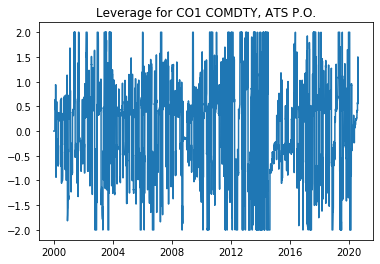

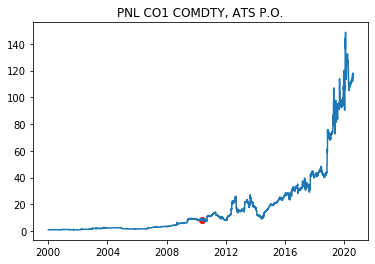

***************** SP1 INDEX
** Minimize: Target:sharpe
optimized X:
[-0.1751628   0.25886208  0.07403913  1.         -0.42908963  0.14285714
  1.        ]
Max Leverage:
2.0


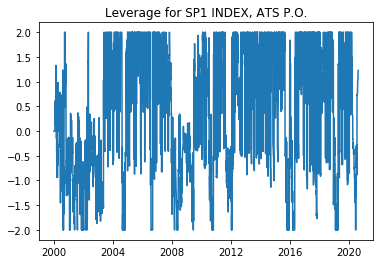

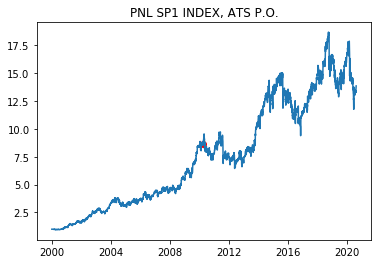

***************** TY1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-0.53277849  0.10202018  0.6536169  -1.          0.66632381  0.14285714
  1.        ]
Max Leverage:
4.0


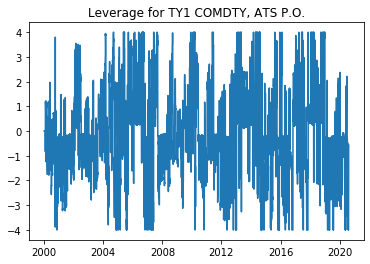

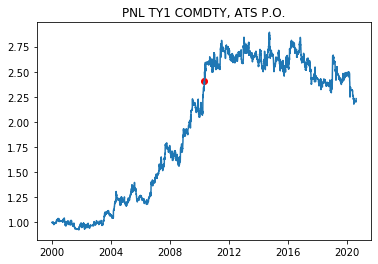

***************** HG1 COMDTY
** Minimize: Target:sharpe
optimized X:
[ 1.         -1.          1.          1.          0.27026294  0.14285714
  0.12494471]
Max Leverage:
2.0


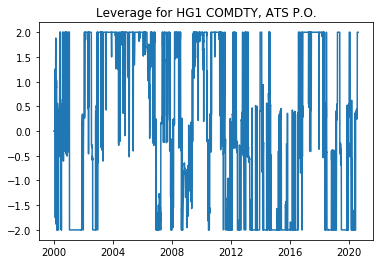

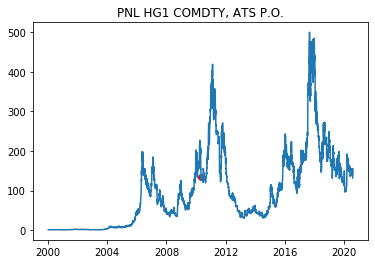

***************** NQ1 INDEX
** Minimize: Target:sharpe
optimized X:
[ 0.373794    0.11018521  0.05144227  0.21859585 -0.31301615  0.14285714
  1.        ]
Max Leverage:
2.0


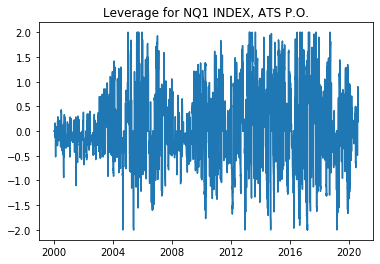

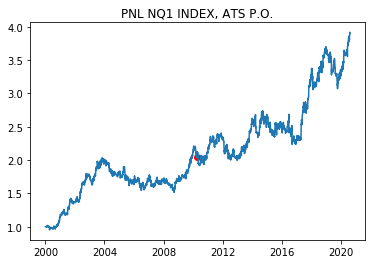

***************** GC1 COMDTY
** Minimize: Target:sharpe
optimized X:
[-1.          1.          1.          1.         -0.70436469  0.14285714
  1.        ]
Max Leverage:
2.0


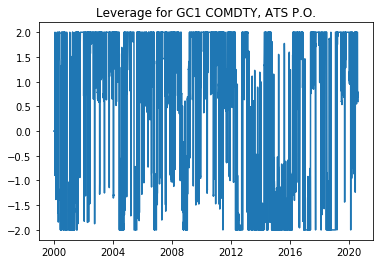

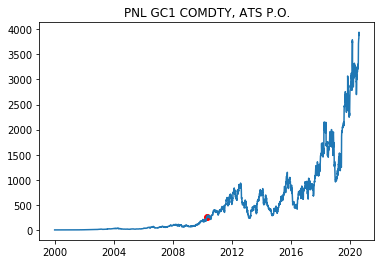

In [8]:
###OPTIMISATION OF ALGORITHMIC TRADING STRATEGIES (ATS)
## ALGO TRADING STRATEGIES ARE FIXED 
## EXAMPLES: MACD(50,200), RSI(14), BOLLINGER BANDS ETC
# PROGRAM WILL OPTIMISE THE WEIGHTS BETWEEN STRATEGIES PER ASSET, AND THEN OPTIMIZE THE WEIGHTS BETWEEN ASSETS
# portfolio of Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures


 
# %% build and backtest all


def run(asset,start_date,end_date):
    #load Bloomberg data for the asset between start_date and end_date
    df = bbload(asset,start_date,end_date)

    # create features and signals
    df = feature(df,start_date,end_date)
    s  = signal(df)

    #backtest and optimize the x vector. All results in p.F
    F['optTarget'] = 'sharpe'
    
    backtest() # run optimization per asset and backtesting (optimize between ATS for each asset)
    plotresult(pp2) #plotting

    
#%% Run each asset separately and store the PNL for each. Weights are optimized between ATS for each asset   

PNL = pd.DataFrame()
POS = pd.DataFrame()
dPrices = pd.DataFrame()

for i in range( len(assets) ):
    asset = assets[i]
    print('***************** '+ asset)
    run(asset,start_date,end_date)     
    name = F['name'] #name of asset
    PNL[name] = F['pnl'].copy() # daily return per asset (p.F is a dataframe that gets written over for each asset)
    POS[name] = F['netlev'].copy() #daily net delta per asset (before asset portfolio optimization) 
    dPrices[name] = F['d']['close'].copy() #daily price per asset



### Part II: 2nd optimization: Getting weight vector between assets

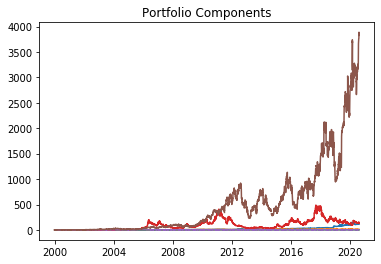

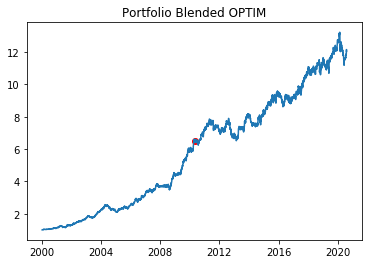

In [9]:
### optimize portfolio of assets (2nd optimization)
PF = PNL
xb = pfopt(PNL) #optimize between weights of assets (and plot PNL of each)

PNLw = PNL*xb  # total weighted pnl

pfcumpnl = PNLw.sum(axis=1).cumsum().apply(np.exp) #cumulative returns+1, ie the path of $1 over time

plt.plot(PNL.cumsum().apply(np.exp)) #plotting each portfolio component before weights between them
plt.title('Portfolio Components')
pp2.savefig()
plt.show()

v = myvars() #loading global constraints variables
n = int(len(pfcumpnl) * (1-test_size))  #point where out of sample starts
plt.plot(pfcumpnl) #plotting results of $1 invested at start in global portfolio
plt.title('Portfolio Blended OPTIM')
plt.scatter(pfcumpnl.index[n],pfcumpnl[n],color='r') # Red point is where Testing data starts
pp2.savefig()
plt.show()

pp2.close()

## 4) Results ATS Portfolio Optimization

In [10]:
n = len(pfcumpnl)
m = int(n* (1-test_size))  #point where out of sample starts
pfcumpnlOS=pfcumpnl[m:n]/pfcumpnl[m]
pfcumpnlIS=pfcumpnl[:m]

showmetrics(pfcumpnlOS, in_or_out_of_sample='out of sample', model='ATS P.O.')
showmetrics(pfcumpnlIS, in_or_out_of_sample='in sample', model='ATS P.O.')


Portfolio Sharpe out of sample, ATS P.O.:  0.57
Annualized returns out of sample, ATS P.O.:  0.0605
Annualized volatility out of sample, ATS P.O.:  0.1054
Portfolio Sharpe in sample, ATS P.O.:  1.83
Annualized returns in sample, ATS P.O.:  0.1957
Annualized volatility in sample, ATS P.O.:  0.1068


## 5) Results Portfolio model of 25% in AdaBoost, 25% Random Forest, 50% ATS Portfolio Optimization

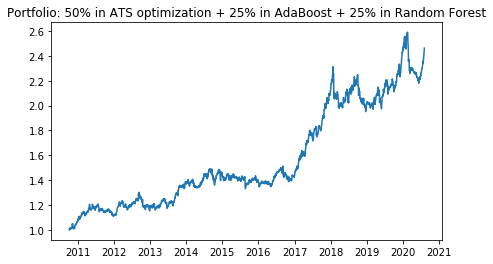

Portfolio Sharpe out of sample, Total portfolio:  0.95
Annualized returns out of sample, Total portfolio:  0.096
Annualized volatility out of sample, Total portfolio:  0.1012


In [11]:
def plot_total_portfolio(pfcumpnl, average_mean, test_size,pp):

    n = len(pfcumpnl)
    m = int(n* (1-test_size))  #point where out of sample starts
    pfcumpnlOS=pfcumpnl[m:n]/pfcumpnl[m]
    portfolio=(pfcumpnlOS+average_mean)/2
    portfolio=portfolio.dropna()
    portfolio=portfolio/portfolio[0]
    plt.figure(figsize=(7,4))
    plt.plot(portfolio)
    plt.title("Portfolio: 50% in ATS optimization + 25% in AdaBoost + 25% in Random Forest")
    pp.savefig()
    plt.show()
    return portfolio

portfolio=plot_total_portfolio(pfcumpnl, average_mean, test_size,pp=pp)

showmetrics(portfolio, in_or_out_of_sample='out of sample', model='Total portfolio')

## 6) Benchmark Buy and Hold portfolio

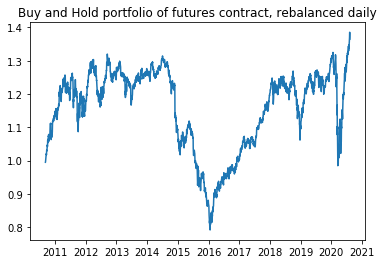

In [12]:
tot_return=pd.Series()
for asset in assets:
    asset=asset[:3]
    tot_return=pd.concat([tot_return,features_dict[asset].ret], axis=1)
tot_return.drop(columns=0).dropna()
n=len(tot_return)
plt.plot(tot_return.mean(axis=1)[int(n*(1-test_size)):n].cumsum().apply(np.exp))
plt.title('Buy and Hold portfolio of futures contract, rebalanced daily')
pp.savefig()
plt.show()
benchmark=tot_return.mean(axis=1)[int(n*(1-test_size)):n].cumsum().apply(np.exp)

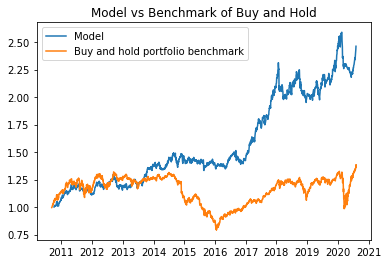

In [13]:
plt.plot(portfolio, label='Model')
plt.plot(benchmark, label ='Buy and hold portfolio benchmark')
plt.title("Model vs Benchmark of Buy and Hold")
plt.legend()
pp.savefig()
plt.show()

In [14]:
showmetrics(benchmark, in_or_out_of_sample='out of sample', model='Benchmark')

Portfolio Sharpe out of sample, Benchmark:  0.25
Annualized returns out of sample, Benchmark:  0.0311
Annualized volatility out of sample, Benchmark:  0.1252


## 7) Positions (assuming constant AUM over time)

In [15]:
#Trades and net leverage

MLpositions=(positions_rf.dropna()+positions_ada.dropna())/4
tot_positions=MLpositions.dropna()+POS/2

In [16]:
tot_positions=round(tot_positions.dropna())
tot_positions

,CO1,SP1,TY1,HG1,NQ1,GC1
date,,,,,,
2010-10-06,0.0,279.0,1704.0,650.0,2023.0,710.0
2010-10-07,680.0,279.0,2001.0,642.0,2013.0,685.0
2010-10-08,0.0,280.0,2072.0,1.0,2006.0,692.0
2010-10-11,0.0,287.0,2158.0,1.0,2110.0,689.0
2010-10-12,0.0,287.0,-0.0,638.0,2090.0,767.0
...,...,...,...,...,...,...
2020-07-31,1.0,91.0,4292.0,845.0,202.0,466.0
2020-08-03,1071.0,93.0,4247.0,1.0,0.0,464.0
2020-08-04,0.0,99.0,-2.0,817.0,0.0,425.0


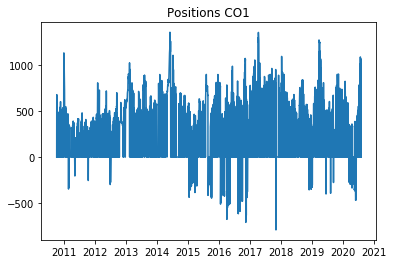

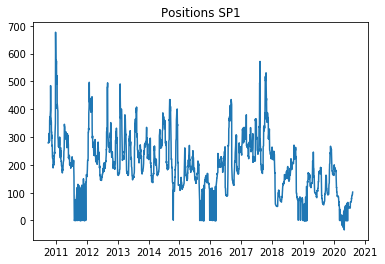

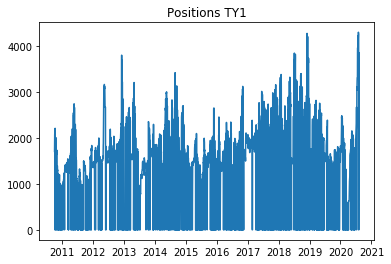

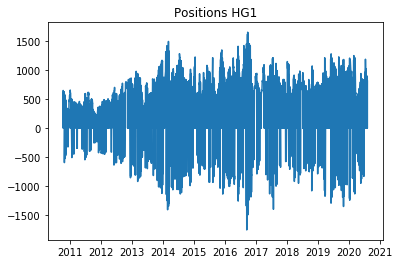

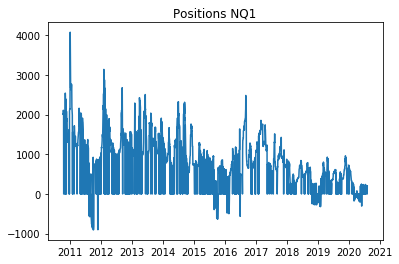

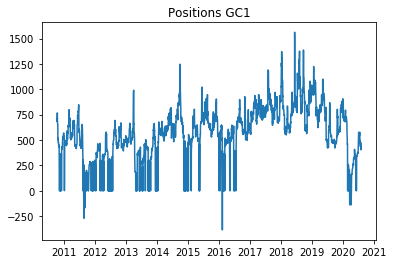

In [17]:

for name in tot_positions.columns:
    plt.plot(tot_positions[name])
    plt.title('Positions '+name)
    pp.savefig()
    plt.show()

## 8) Trades in lots

In [18]:
trades=tot_positions-tot_positions.shift(1)
trades=trades.dropna()

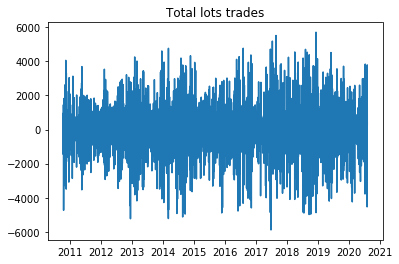

In [19]:
plt.plot(trades.sum(axis=1))
plt.title('Total lots trades')
pp.savefig()
plt.show()

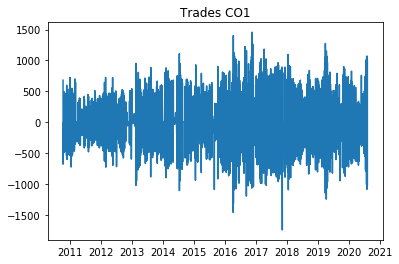

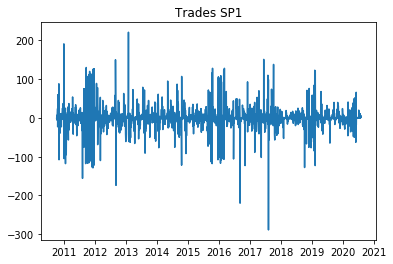

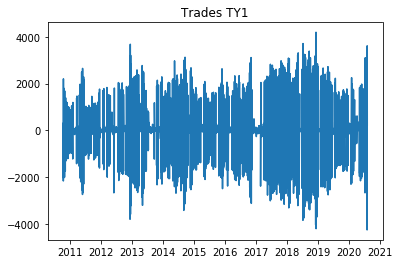

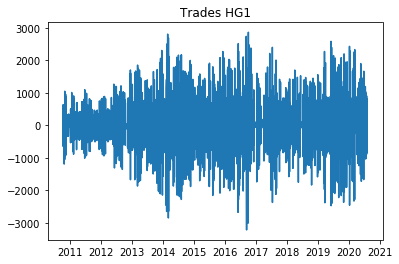

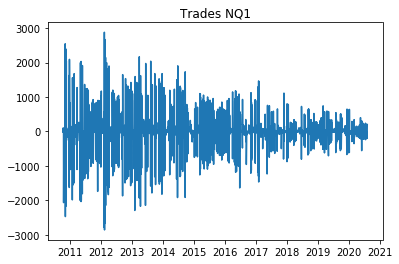

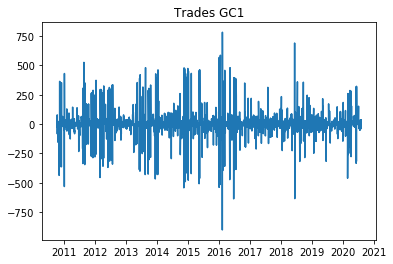

In [20]:
for name in trades.columns:
    plt.plot(trades[name])
    plt.title('Trades '+name)
    pp.savefig()
    plt.show()

## 9) Net exposure, or leverage

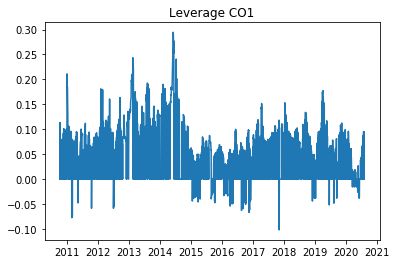

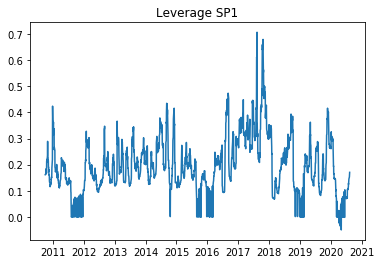

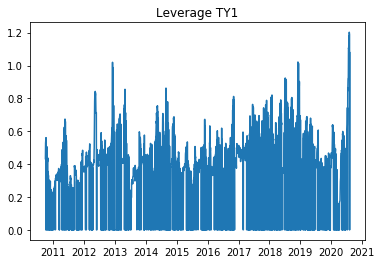

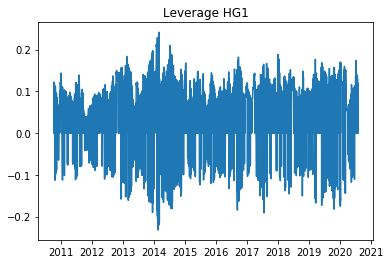

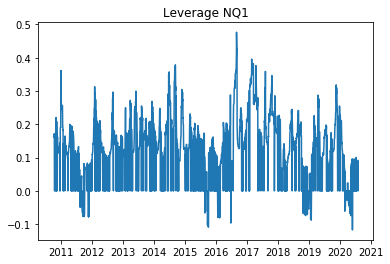

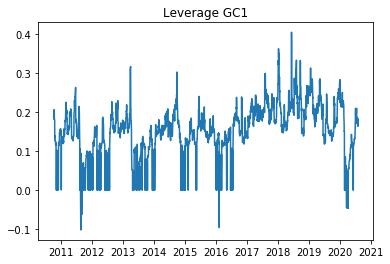

In [21]:
i=0
leverage=pd.DataFrame()

for name in tot_positions.columns:
    price_clean=pd.DataFrame()
    price=prices_dict[name].close.copy()
    position=tot_positions[name]
    n=len(position)
    m=len(price_clean)
    leverage[name]=lot_size[i]*position*price/aum
    leverage[name]=leverage[name].dropna()
    plt.plot(leverage[name].dropna())
    plt.title('Leverage '+name)
    pp.savefig()
    plt.show()
    i+=1

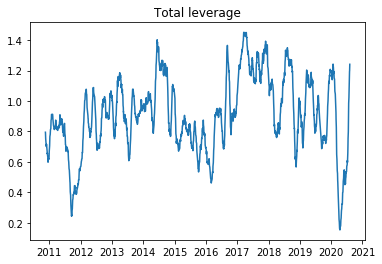

In [22]:
tot_leverage=leverage.dropna().sum(axis=1)
plt.plot(tot_leverage.rolling(30).mean())
plt.title('Total leverage')
pp.savefig()
plt.show()

## 10) Transaction costs

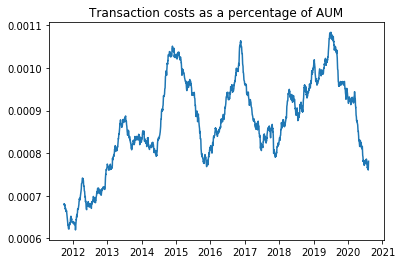

In [23]:
#transaction costs estimation $4 per lot /AUM
plt.plot(np.abs(trades).sum(axis=1).rolling(250).sum()/aum)
plt.title('Transaction costs as a percentage of AUM')
pp.savefig()
plt.show()
pp.close()

Transaction costs are less than 0.1% per year. We can therefore neglect them

## 11) Trades to do at close

In [24]:
for asset in trades.columns:
    print("Trades for "+asset+" :", trades[asset].tail(1)[0]) #printing the trades to make now

Trades for CO1 : -1016.0
Trades for SP1 : 2.0
Trades for TY1 : 233.0
Trades for HG1 : 815.0
Trades for NQ1 : 202.0
Trades for GC1 : 36.0
